In [242]:
import numpy as np
import argparse
import torch
import cv2 as cv

from natsort import natsorted

import os
import os.path as p

from torch.utils.data import DataLoader, ConcatDataset
import torch.nn.functional as F

import pandas as pd

import utils
import seg.train_seg as seg
import data.datasets as data
import stn.stn_dataset as stn_dataset
import stn.train_stn as stn
import fine_tune

whole_dataset = data.get_whole_dataset('lesion', 'dermquest', stn_transformed=False)


In [243]:
unet = 'predictions/isic_baseline/dermquest'
stnunet = 'predictions/isic_stnunet/dermquest'

preds_unet = [cv.imread(p.join(unet, f), cv.IMREAD_GRAYSCALE) for f in natsorted(os.listdir(unet))]
preds_stnunet = [cv.imread(p.join(stnunet, f), cv.IMREAD_GRAYSCALE) for f in natsorted(os.listdir(stnunet))]

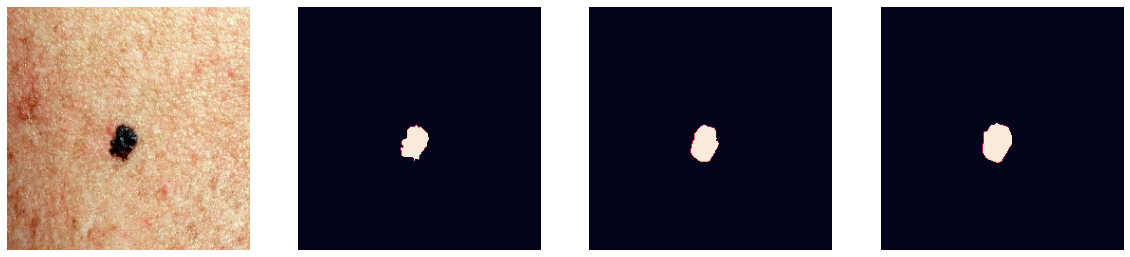

In [244]:
for i, (x, y) in enumerate(whole_dataset):
  if i < 70:
    continue
  x = x.squeeze().numpy().transpose(1, 2, 0) + 0.5
  y = y.squeeze().numpy()
  utils.show_images_row([x, y, preds_unet[i], preds_stnunet[i]], figsize=(20, 5))
  break

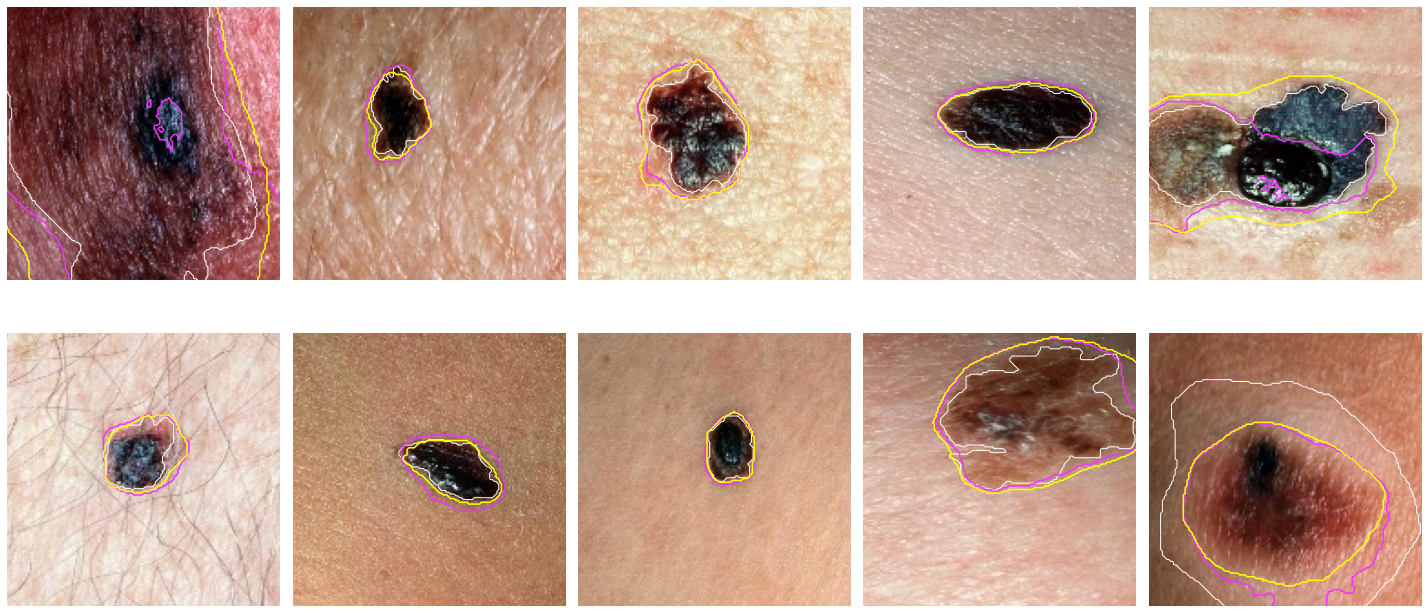

In [245]:
import matplotlib.pyplot as plt
from skimage import measure

indices = range(63,93,3)
fig, axs = plt.subplots(2, len(indices) // 2, figsize=(20, 10))
axs = axs.flatten()

for idx, ax in zip(indices, axs):
    ax.axis('off')
    x = whole_dataset[idx][0].squeeze().numpy().transpose(1, 2, 0) + 0.5
    y = whole_dataset[idx][1].squeeze().numpy()
    y_unet = preds_unet[idx]
    y_stnunet = preds_stnunet[idx]

    y_contours = measure.find_contours(y, 0.5)
    unet_contours = measure.find_contours(y_unet, 0.5)
    stnunet_contours = measure.find_contours(y_stnunet, 0.5)

    ax.imshow(x)

    for contour in y_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1, color='white')

    for contour in unet_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='#F433FF')

    for contour in stnunet_contours:
        ax.plot(contour[:, 1], contour[:, 0], linewidth=1.5, color='yellow')

    ax.axis([50, 200, 50, 200])

plt.tight_layout()
plt.savefig('plots/output.png', bbox_inches='tight')

In [204]:
import pandas as pd
import os
from scipy.stats import ranksums
import scipy.stats as st
import numpy as np

results_folder = 'results'
result_files = os.listdir(results_folder)

dataset_file_combinations = [
  ('dermis', 'dermis'),
  ('dermquest', 'dermquest'),
  #('isic', 'isic'),
  ('ph2', 'ph2'),
  ('dermofit', 'dermofit'),
  ('ph2', 'dermofit'),
  ('dermofit', 'ph2'),
  ('dermis', 'dermquest'),
  ('dermquest', 'dermis'),
  ('dermquest', 'isic'),
  ('dermis', 'isic'),
  #('isic', 'ph2'),
  ('ph2', 'isic'),
]

input_sizes = [64, 128, 256, 512]

dataset_combinations = []
results = []

def pretty_dataset_name(dataset):
  if dataset == 'dermofit':
    return 'Dermofit'
  if dataset == 'dermis':
    return 'DermIS'
  elif dataset == 'isic':
    return 'ISIC'
  elif dataset == 'dermquest':
    return 'DermQuest'
  elif dataset == 'ph2':
    return 'PH2'

for dataset_train, dataset_test in dataset_file_combinations:
  dataset_result_files_all = [f for f in result_files if f'train={dataset_train}' in f and f.split('_')[-1] == 'final.csv']
  dataset_result_files_all.sort()

  dataset_test_files_all = [f for f in dataset_result_files_all if f'test={dataset_test}' in f]
  dataset_test_files_all.sort(reverse=True)

  for f in dataset_test_files_all:
    result_df = pd.read_csv(os.path.join(results_folder, f), index_col=0)

    f = f.replace('.csv', '')
    input_size = int(f.split('input_size=')[-1].split('_')[0])
    model = f.split('_')[0]

    result_df['input_size'] = input_size
    result_df['model'] = model

    train_dataset = f.split('_')[1].split('=')[-1]
    test_dataset = f.split('_')[2].split('=')[-1]

    train_dataset = pretty_dataset_name(train_dataset)
    test_dataset = pretty_dataset_name(test_dataset)

    dataset_combination_category = f'{train_dataset} -> {test_dataset}'
    result_df['dataset_combination'] = dataset_combination_category

    results.append(result_df)


In [205]:
results_df = pd.concat(results)
results_df['dataset_combination'] = results_df['dataset_combination'].astype('category')
results_df['model'] = results_df['model'].astype('category')

results_df.head()

,dsc,prec,rec,th_jacc,input_size,model,dataset_combination
0,0.821293,0.964286,0.715232,0.696774,64,unet,DermIS -> DermIS
1,0.194842,0.111769,0.758929,0.000000,64,unet,DermIS -> DermIS
2,0.301151,0.177268,1.000000,0.000000,64,unet,DermIS -> DermIS
3,0.240185,0.142857,0.753623,0.000000,64,unet,DermIS -> DermIS
4,0.908350,0.931106,0.886680,0.832090,64,unet,DermIS -> DermIS


In [215]:
import seaborn as sns
import matplotlib.pyplot as plt

def metric_table(metric, title, df):
  columns = ['model', 'dataset_combination', metric, 'input_size']
  table = pd.DataFrame(columns=columns)

  for dataset_combination in df.dataset_combination.unique():
    for input_size in df.input_size.unique():
      unet = df[(df['dataset_combination'] == dataset_combination) & (df['model'] == 'unet') & (df['input_size'] == input_size)][metric]
      stnunet = df[(df['dataset_combination'] == dataset_combination) & (df['model'] == 'stnunet') & (df['input_size'] == input_size)][metric]

      table.loc[len(table)] = {
        'model': 'U-Net',
        'input_size': input_size,
        'dataset_combination': dataset_combination,
        metric: f'{unet.mean() * 100:.2f} ± {unet.std() * 100:.2f}',
      }

      table.loc[len(table)] = {
        'model': 'STN+U-Net',
        'input_size': input_size,
        'dataset_combination': dataset_combination,
        metric: f'{stnunet.mean() * 100:.2f} ± {stnunet.std() * 100:.2f}',
      }

  # sort by dataset combination
  table = table.sort_values(['input_size', 'dataset_combination'])
  return table

In [216]:
metrics = [('dsc', 'Dice coefficient'), ('rec', 'Recall'), ('th_jacc', 'Thresholded Jaccard index')]
tables = [metric_table(metric, title, results_df) for metric, title in metrics]
# join tables
table = tables[0]
for t in tables[1:]:
  table = table.merge(t, on=['model', 'dataset_combination', 'input_size'])

# drop where th_jacc is not significant
#table = table[table['p_th_jacc'].astype(float) < 0.05]

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
  display(table)

,model,dataset_combination,dsc,input_size,rec,th_jacc
0,U-Net,DermIS -> DermIS,85.51 ± 15.50,64,89.59 ± 10.57,70.31 ± 31.38
1,STN+U-Net,DermIS -> DermIS,87.01 ± 15.06,64,90.09 ± 10.63,74.57 ± 27.97
2,U-Net,DermIS -> DermQuest,77.11 ± 13.58,64,68.19 ± 18.25,43.40 ± 34.37
3,STN+U-Net,DermIS -> DermQuest,80.94 ± 12.85,64,74.31 ± 17.26,54.56 ± 31.45
4,U-Net,DermIS -> ISIC,70.67 ± 23.56,64,86.48 ± 21.23,41.15 ± 36.55
5,STN+U-Net,DermIS -> ISIC,72.88 ± 21.59,64,86.91 ± 20.86,43.02 ± 36.81
6,U-Net,DermQuest -> DermIS,78.94 ± 18.81,64,96.71 ± 3.70,54.98 ± 34.36
7,STN+U-Net,DermQuest -> DermIS,81.85 ± 17.24,64,94.98 ± 5.46,60.87 ± 32.66
8,U-Net,DermQuest -> DermQuest,87.75 ± 9.07,64,89.66 ± 9.51,71.61 ± 29.56
9,STN+U-Net,DermQuest -> DermQuest,87.83 ± 8.97,64,89.07 ± 10.65,73.96 ± 25.84


In [234]:
# result table 1 in paper

combinations = [
  'DermIS -> DermIS',
  'DermQuest -> DermQuest',
  'DermIS -> DermQuest',
  'DermQuest -> DermIS',
]

table_df = table[table['dataset_combination'].isin(combinations)].copy()

metrics = [('dsc', 'DSC'), ('th_jacc', 'Th. Jacc.')]
titles = ['U-Net', 'Ours']

columns = ['Size'] +  ['DSC', 'Th. Jacc.'] * 2
rows = []

def rename_comb(comb):
  if comb == 'DermIS -> DermIS':
    return 'DermIS'
  if comb == 'DermQuest -> DermQuest':
    return 'DermQuest'
  if comb == 'DermIS -> DermQuest':
    return 'DermIS $\\rightarrow$ DermQuest'
  if comb == 'DermQuest -> DermIS':
    return 'DermQuest $\\rightarrow$ DermIS'

for comb in combinations:
  title_column = rename_comb(comb)
  # make multicolumn title row
  rows.append([f'\\hline\\multicolumn{{7}}{{c}}{{{title_column}}}', ''])
  for input_size in table_df.input_size.unique():
    row = [input_size]
    models = ['U-Net', 'STN+U-Net']
    for model in models:
      for metric, title in metrics:
        m = (table_df[(table_df['dataset_combination'] == comb) & (table_df['input_size'] == input_size) & (table_df['model'] == model)][metric].values[0])
        row.append(m)
          
    rows.append(row)

rows = np.array(rows)

from tabulate import tabulate
latex = tabulate(rows, headers=columns, tablefmt='latex_raw', floatfmt='.3f')
latex = latex.replace('±', '$\pm$')
latex = latex.replace('&               &               &               &               \\', '\\')
print(latex)


\begin{tabular}{lllll}
\hline
 Size                                                     & DSC           & Th. Jacc.     & DSC           & Th. Jacc.     \\
\hline
 \hline\multicolumn{7}{c}{DermIS}                         \\
 64                                                       & 85.51 $\pm$ 15.50 & 70.31 $\pm$ 31.38 & 87.01 $\pm$ 15.06 & 74.57 $\pm$ 27.97 \\
 128                                                      & 86.53 $\pm$ 15.71 & 72.21 $\pm$ 30.78 & 88.82 $\pm$ 11.93 & 75.84 $\pm$ 28.41 \\
 256                                                      & 88.09 $\pm$ 14.58 & 73.58 $\pm$ 33.01 & 89.88 $\pm$ 12.49 & 77.04 $\pm$ 30.77 \\
 512                                                      & 89.85 $\pm$ 16.90 & 81.32 $\pm$ 26.32 & 90.35 $\pm$ 17.07 & 83.40 $\pm$ 24.35 \\
 \hline\multicolumn{7}{c}{DermQuest}                      \\
 64                                                       & 87.75 $\pm$ 9.07  & 71.61 $\pm$ 29.56 & 87.83 $\pm$ 8.97  & 73.96 $\pm$ 25.84 \\
 128       

/tmp/ipykernel_3305433/1420814899.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  rows = np.array(rows)


In [198]:
combinations = results_df['dataset_combination'].tolist()
combinations = [c.split(' -> ') for c in combinations]
is_in_sample = [c[0] == c[1] for c in combinations]

in_sample_results_df = results_df[is_in_sample]
in_sample_results_df['dataset_combination'] = in_sample_results_df['dataset_combination'].cat.remove_unused_categories()
out_sample_results_df = results_df[~np.array(is_in_sample)]
out_sample_results_df['dataset_combination'] = out_sample_results_df['dataset_combination'].cat.remove_unused_categories()

/tmp/ipykernel_3305433/566609682.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  in_sample_results_df['dataset_combination'] = in_sample_results_df['dataset_combination'].cat.remove_unused_categories()
/tmp/ipykernel_3305433/566609682.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out_sample_results_df['dataset_combination'] = out_sample_results_df['dataset_combination'].cat.remove_unused_categories()


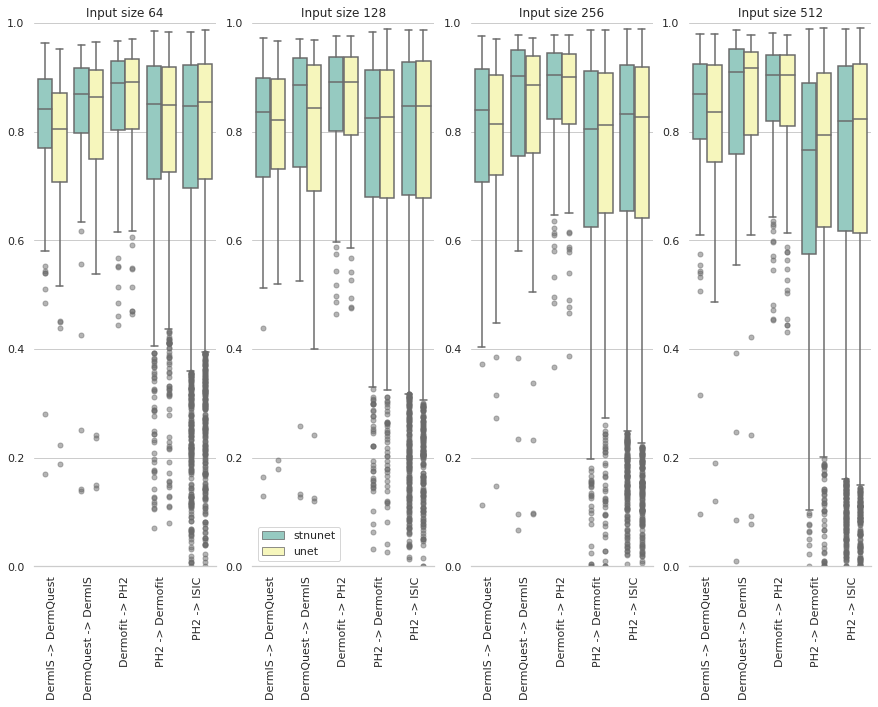

In [199]:
def box_plot_metric(metric, title, input_size, df, ax):
  sns.set_theme(style="whitegrid")
  # transparent fliers
  flierprops = dict(marker='o', alpha=0.5)
  width = df['dataset_combination'].nunique() * 0.7
  df_plot = df[df['input_size'] == input_size]
  #ax = sns.violinplot(x=metric, y="dataset_combination", hue="model", data=df, palette="Set3", split=True, inner="quartile")
  ax = sns.boxplot(x="dataset_combination", y=metric, hue="model", data=df_plot, palette="Set3", flierprops=flierprops, ax=ax)
  ax.set_ylabel('')
  ax.set_xlabel('')
  ax.set_title(title)
  ax.set_ylim(0, 1)
  # rotate labels
  for tick in ax.get_xticklabels():
    tick.set_rotation(90)

  sns.despine(ax=ax, left=True, bottom=False, right=True, top=True)

input_sizes = [64, 128, 256, 512]
fig, axs = plt.subplots(1, len(input_sizes), figsize=(15, 10))
axs = axs.flatten()

for i, input_size in enumerate(input_sizes):
  ax = axs[i]
  box_plot_metric('dsc', 'Dice Coefficient', input_size, out_sample_results_df, ax)
  ax.set_title(f'Input size {input_size}')
  if i == 1:
    sns.move_legend(ax, 'best', title=None)
  else:
    ax.legend().remove()

In [200]:
print(out_sample_results_df['dataset_combination'].unique())

['PH2 -> Dermofit', 'Dermofit -> PH2', 'DermIS -> DermQuest', 'DermQuest -> DermIS', 'PH2 -> ISIC']
Categories (5, object): ['DermIS -> DermQuest', 'DermQuest -> DermIS', 'Dermofit -> PH2', 'PH2 -> Dermofit', 'PH2 -> ISIC']


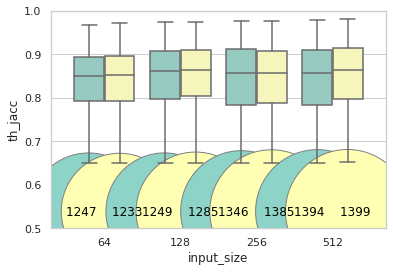

In [203]:
dataset_combination = 'PH2 -> ISIC'
df_plot = out_sample_results_df[out_sample_results_df['dataset_combination'] == dataset_combination]
succeeded = df_plot[df_plot['th_jacc'] >= 0.65]
failed = df_plot[df_plot['th_jacc'] <= 0.65]
ax = sns.boxplot(x="input_size", y="th_jacc", hue="model", data=succeeded, palette="Set3")
ax.set_ylim(0.5, 1)
# remove legend
ax.legend().remove()

unet_color = sns.color_palette("Set3")[1]
stnunet_color = sns.color_palette("Set3")[0]

# Add number of failed images for each box plot
for xtick in ax.get_xticks():
  xtick = int(xtick)
  input_size = input_sizes[xtick]
  unet_failed = len(failed[(failed['model'] == 'unet') & (failed['input_size'] == input_size)])
  stnunet_failed = len(failed[(failed['model'] == 'stnunet') & (failed['input_size'] == input_size)])
  ax.text(xtick, 0.53, f'{stnunet_failed}    {unet_failed}', horizontalalignment='center', color='black')

  # draw two circles with radii proportional to the number of failed images
  ax.scatter(xtick - 0.21, 0.54, s=stnunet_failed*11, facecolors=stnunet_color, edgecolors='gray')
  ax.scatter(xtick + 0.19, 0.54, s=unet_failed*11, facecolors=unet_color, edgecolors='gray')

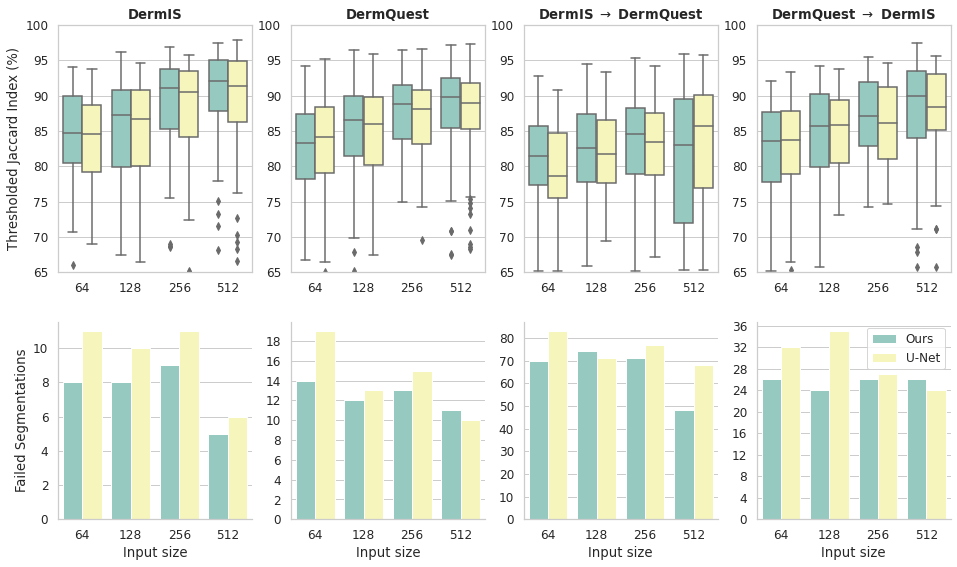

In [265]:
from matplotlib.ticker import MaxNLocator

# increase plot font size
sns.set(font_scale=1.1, style='whitegrid')

# convert above block into 4 subplots
fig, axs = plt.subplots(2, 4, figsize=(16, 10))
axs = axs.flatten()

radius_factors = [1.4, 15, 11, 30]

df_block = results_df.copy()

dataset_combinations = [
  'DermIS -> DermIS',
  'DermQuest -> DermQuest',
  'DermIS -> DermQuest',
  'DermQuest -> DermIS',
]

# box plots
for i, dataset_combination in enumerate(dataset_combinations):
  df_plot = df_block[df_block['dataset_combination'] == dataset_combination]
  succeeded = df_plot[df_plot['th_jacc'] >= 0.65].copy()
  succeeded['th_jacc'] = succeeded['th_jacc'] * 100

  ax = sns.boxplot(x="input_size", y="th_jacc", hue="model", data=succeeded, palette="Set3", ax=axs[i])
  ax.set_ylim(65, 100)
  # remove legend
  ax.legend().remove()
  ax.set_title(rename_comb(dataset_combination), fontweight='bold')
  ax.set_xlabel('')

  if i > 0:
    ax.set_ylabel('')
  else:
    ax.set_ylabel('Thresholded Jaccard Index (%)')

# bar plots of failed images
for i, dataset_combination in enumerate(dataset_combinations):
  df_plot = df_block[df_block['dataset_combination'] == dataset_combination].copy()
  df_plot.loc[df_plot['th_jacc'] >= 0.65, 'failed'] = 0
  df_plot.loc[df_plot['th_jacc'] < 0.65, 'failed'] = 1
  ax = axs[i+4]

  # make axis less tall
  box = ax.get_position()
  ax.set_position([box.x0, box.y0 + box.height * 0.2, box.width, box.height * 0.8])

  df_plot['model'] = df_plot['model'].replace({'unet': 'U-Net', 'stnunet': 'Ours'})
  ax = sns.barplot(x="input_size", y="failed", hue="model", data=df_plot, palette="Set3", ax=ax, ci=None, estimator=np.sum)

  # despine
  sns.despine(ax=ax, left=False, bottom=False, right=True, top=True)
  # make sure ticks are ints
  ax.yaxis.set_major_locator(MaxNLocator(integer=True))

  # remove legend
  if i < 3:
    ax.legend().remove()
  else:
    sns.move_legend(ax, 'best', title=None)

  ax.set_xlabel('Input size')

  if i > 0:
    ax.set_ylabel('')
  else:
    ax.set_ylabel('Failed Segmentations')

plt.savefig('plots/mostart/boxplots.png', bbox_inches='tight')
plt.savefig('plots/mostart/boxplots.pdf', bbox_inches='tight')

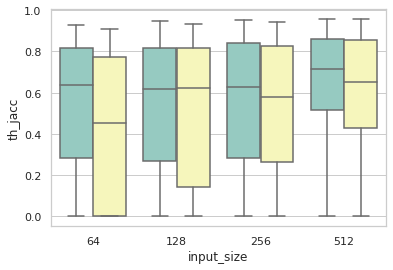

In [115]:
dataset_combination = 'DermIS -> DermQuest'
df_plot = out_sample_results_df[out_sample_results_df['dataset_combination'] == dataset_combination]
ax = sns.boxplot(x="input_size", y="th_jacc", hue="model", data=df_plot, palette="Set3")
# remove legend
ax.legend().remove()

In [78]:
# number of th_jacc failures
out_sample_results_df[out_sample_results_df['th_jacc'] < 0.5].groupby(['model', 'input_size', 'dataset_combination']).count()

dsc  prec  rec  th_jacc
model   input_size dataset_combination                         
stnunet 64         DermIS -> DermQuest   51    51   51       51
                   DermQuest -> DermIS   19    19   19       19
                   Dermofit -> PH2       48    48   48       48
                   PH2 -> Dermofit      533   533  533      533
        128        DermIS -> DermQuest   59    59   59       59
                   DermQuest -> DermIS   23    23   23       23
                   Dermofit -> PH2       50    50   50       50
                   PH2 -> Dermofit      591   591  591      591
        256        DermIS -> DermQuest   53    53   53       53
                   DermQuest -> DermIS   21    21   21       21
                   Dermofit -> PH2       44    44   44       44
                   PH2 -> Dermofit      641   641  641      641
        512        DermIS -> DermQuest   33    33   33       33
                   DermQuest -> DermIS   20    20   20       20
                   Dermofit -> PH2       49    49   49       49
                   PH2 -> Dermofit      714   714  714      714
unet    64         DermIS -> DermQuest   69    69   69       69
                   DermQuest -> DermIS   27    27   27       27
                   Dermofit -> PH2       53    53   53       53
                   PH2 -> Dermofit      514   514  514      514
        128        DermIS -> DermQuest   61    61   61       61
                   DermQuest -> DermIS   29    29   29       29
                   Dermofit -> PH2       51    51   51       51
                   PH2 -> Dermofit      595   595  595      595
        256        DermIS -> DermQuest   63    63   63       63
                   DermQuest -> DermIS   22    22   22       22
                   Dermofit -> PH2       45    45   45       45
                   PH2 -> Dermofit      642   642  642      642
        512        DermIS -> DermQuest   48    48   48       48
                   DermQuest -> DermIS   20    20   20       20
                   Dermofit -> PH2       48    48   48       48
                   PH2 -> Dermofit      679   679  679      679

In [9]:
# visual results
import test
import numpy as np
import argparse
import torch
import cv2 as cv

import os
import os.path as p

from torch.utils.data import DataLoader, ConcatDataset
import torch.nn.functional as F

import pandas as pd

import utils
import seg.train_seg as seg
import data.datasets as data
import stn.stn_dataset as stn_dataset
import stn.train_stn as stn
import fine_tune
from model import TransformedSegmentation

import matplotlib.pyplot as plt

input_size = 256
subset = 'dermis'
test_subset = 'dermquest' if subset == 'dermis' else 'dermis'
log_name = f'{subset}_final_{input_size}'
fold = 0

test_dataset = data.get_valid_dataset('lesion', test_subset, subjects='all', input_size=input_size)

seg_model = seg.get_model(test_dataset)
seg_checkpoint = test.get_checkpoint('seg', log_name, fold)
seg_model.load_state_dict(seg_checkpoint['model'])
seg_model.eval()
seg_model.cuda()

fine_model = fine_tune.get_model(test_dataset, log_name, fold)
fine_model.output_stn_mask = True
fine_model.output_theta = True
fine_checkpoint = test.get_checkpoint('fine', log_name, fold)
fine_model.load_state_dict(fine_checkpoint['model'])
fine_model.eval()
fine_model.cuda()

n_imgs = 4
# get random images
indices = np.random.choice(len(test_dataset), n_imgs)
imgs = [test_dataset[i][0].unsqueeze(0) for i in indices]
imgs_highres = [test_dataset[i][1].unsqueeze(0) for i in indices]
masks = [test_dataset[i][2].unsqueeze(0) for i in indices]
imgs = torch.cat(imgs)
masks = torch.cat(masks)
imgs = imgs.cuda()
masks = masks.cuda()
imgs_highres = torch.cat(imgs_highres).cuda()

with torch.no_grad():
  # get predictions
  seg_preds = seg_model(imgs)
  rough_preds, fine_preds, bboxes = fine_model(imgs, imgs_highres)

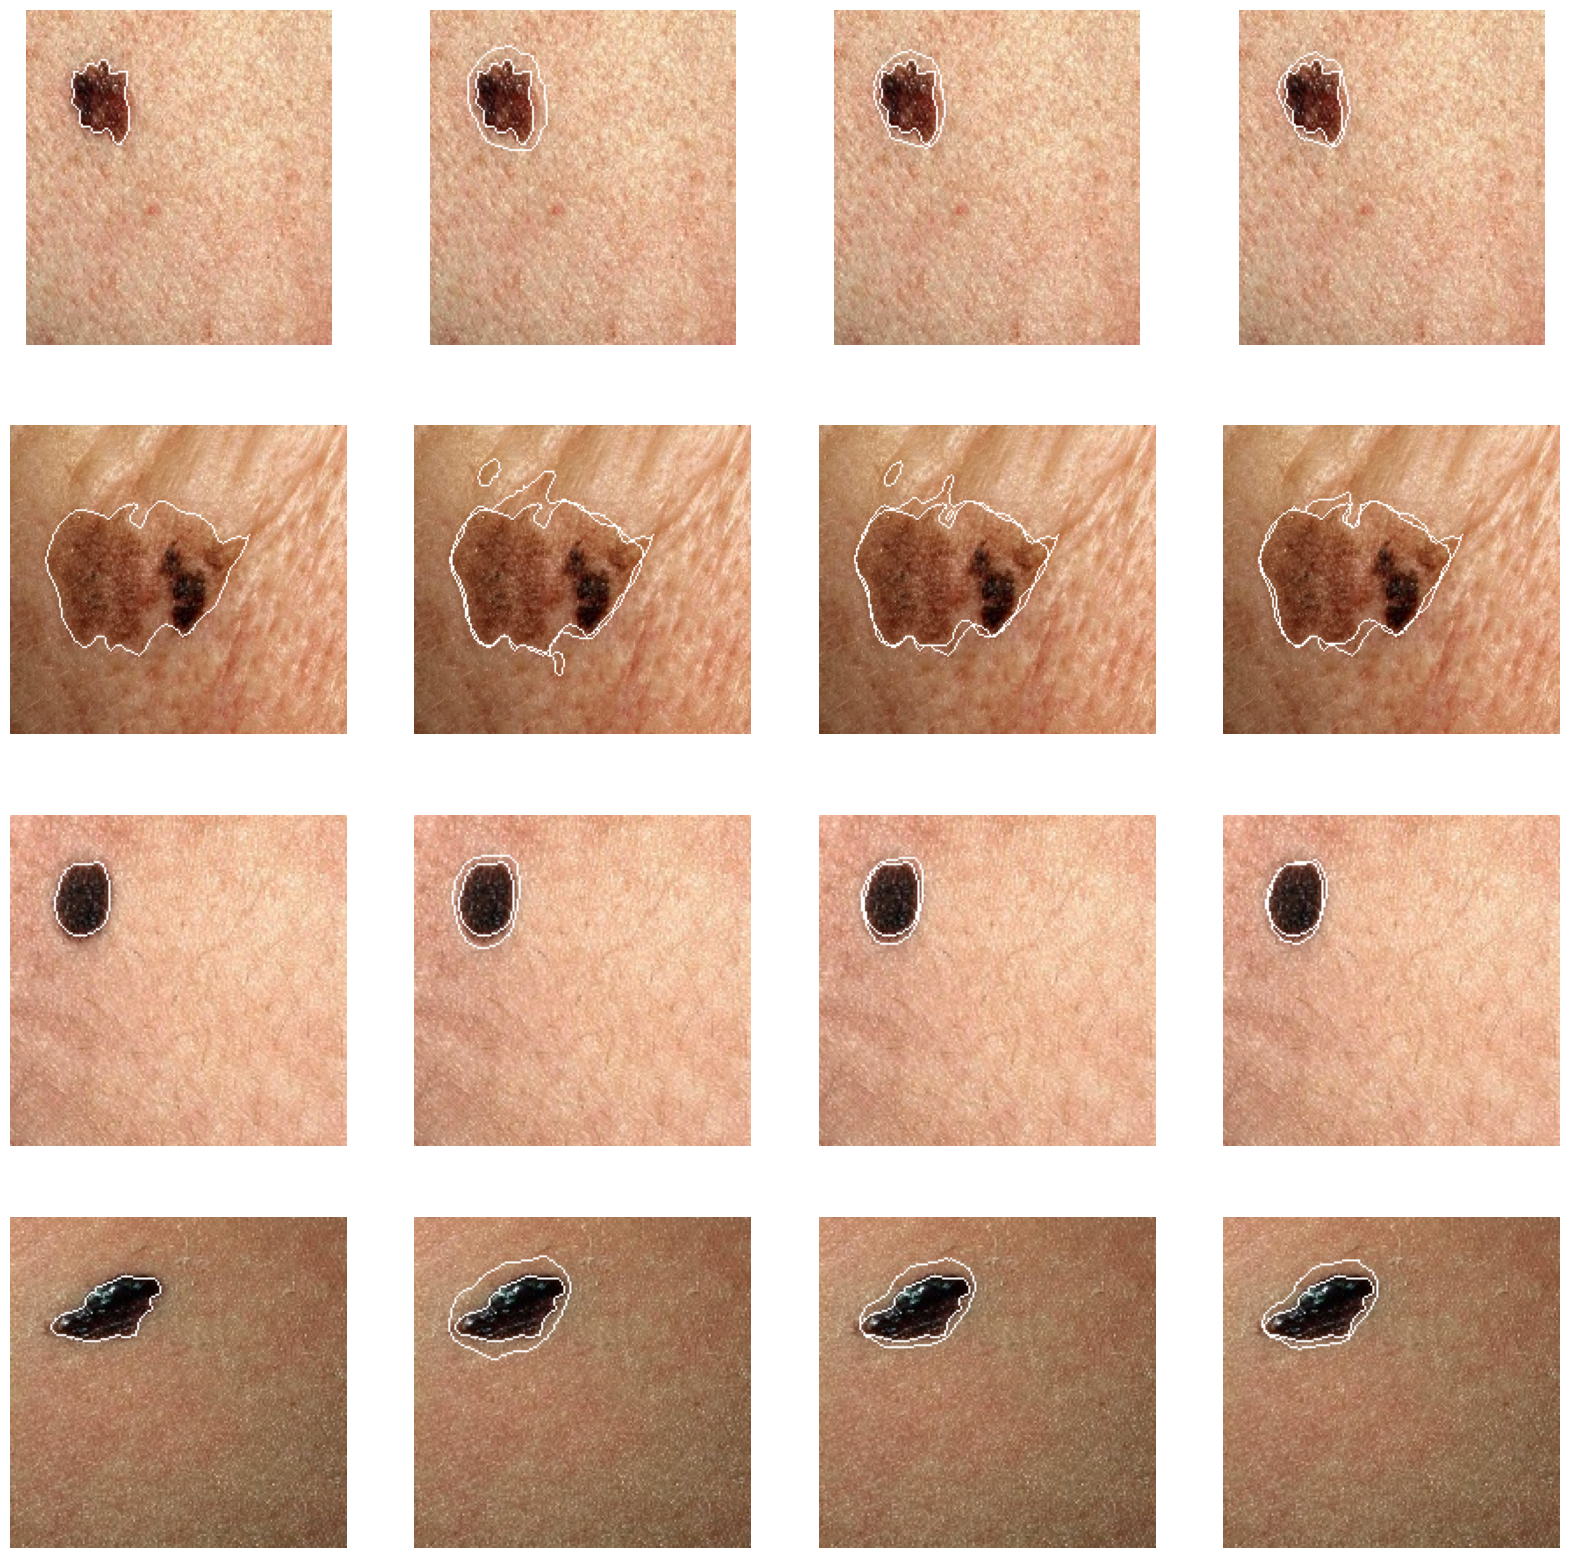

In [18]:
# columns: input image, initial mask, fine mask, seg mask, gt mask
rows = []

def draw_mask_as_contour(img, mask):
  contours = cv.findContours(mask.astype(np.uint8), cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)[0]
  img = img.copy()
  img = cv.drawContours(img, contours, -1, (255, 255, 255), 1)
  return img

def crop_image(img, bbox):
  x, y, w, h = np.array(bbox).astype(int)
  return img[y:y+h, x:x+w]

for i in range(n_imgs):
  img = imgs[i].squeeze().cpu().numpy().transpose(1, 2, 0) + 0.5
  img = (img * 255).astype(np.uint8)

  gt_mask = masks[i].squeeze().cpu().numpy()
  seg_pred = seg_preds[i].squeeze().cpu().numpy()
  seg_pred = utils._thresh(seg_pred)
  rough_pred = rough_preds[i].squeeze().cpu().numpy()
  rough_pred = utils._thresh(rough_pred)
  fine_pred = fine_preds[i].squeeze().cpu().numpy()
  fine_pred = utils._thresh(fine_pred)
  bbox = bboxes[i].squeeze().cpu().numpy()

  # crop all images
  img = crop_image(img, bbox)
  gt_mask = crop_image(gt_mask, bbox)
  seg_pred = crop_image(seg_pred, bbox)
  rough_pred = crop_image(rough_pred, bbox)
  fine_pred = crop_image(fine_pred, bbox)

  # draw contours
  img = draw_mask_as_contour(img.copy(), gt_mask)
  seg_pred = draw_mask_as_contour(img.copy(), seg_pred)
  rough_pred = draw_mask_as_contour(img.copy(), rough_pred)
  fine_pred = draw_mask_as_contour(img.copy(), fine_pred)

  # add to rows
  rows.append([img, seg_pred, rough_pred, fine_pred])

fig, axs = plt.subplots(n_imgs, 4, figsize=(20, 20))
axs = axs.flatten()

for i, row in enumerate(rows):
  for j, img in enumerate(row):
    axs[i * 4 + j].imshow(img)
    axs[i * 4 + j].axis('off')